# Determinando Calorias de Alimentos!

### Mudando tamanho da fonte padrão do Collab

In [ ]:
from IPython.display import HTML
shell = get_ipython()

def adjust_font_size():
  display(
      HTML('''
      <style>
        body {
          font-size: 20px;
        }
      </style>
      ''')
  )

if adjust_font_size not in shell.events.callbacks['pre_execute']:
  shell.events.register('pre_execute', adjust_font_size)

## Processo de Mineração de Dados para Previsão de Calorias em Alimentos

O CRISP-DM (Cross-Industry Standard Process for Data Mining) é um modelo amplamente utilizado para guiar projetos de mineração de dados. Neste contexto, vamos aplicar o CRISP-DM para criar um sistema de predição de calorias em alimentos, utilizando a tabela TACO como dataset.

### 1. Entendimento do Negócio
- Objetivo: Desenvolver um sistema que preveja o teor calórico de alimentos com base em suas características.
- Benefícios esperados: Melhorar a conscientização sobre a ingestão calórica e auxiliar em escolhas alimentares saudáveis.

### 2. Entendimento dos Dados
- Fonte dos Dados: Tabela TACO (Tabela Brasileira de Composição de Alimentos).
- Conteúdo: Informações sobre a composição de diversos alimentos, incluindo calorias, proteínas, gorduras, carboidratos, entre outros.
- Formato dos Dados: Estruturado em tabela EXCEL.

### 3. Preparação dos Dados
- Limpeza dos Dados: Remoção de dados duplicados, tratamento de valores ausentes, correção de erros.
- Seleção de Atributos: Escolha dos atributos mais relevantes para a predição de calorias.
- Transformação dos Dados: Normalização dos dados.

### 4. Modelagem
- Escolha do Modelo: Seleção de algoritmos de machine learning adequados para regressão.
- Treinamento do Modelo: Utilização de técnicas de validação cruzada para avaliar o desempenho do modelo.
- Ajuste de Hiperparâmetros: Otimização dos parâmetros do modelo para melhorar a precisão da predição.

### 5. Avaliação
- Avaliação do Modelo: Verificação do desempenho do modelo utilizando métricas como RMSE (Root Mean Squared Error) e R² (coeficiente de determinação).
- Validação do Modelo: Verificação da generalização do modelo em um conjunto de dados de teste.

### 6. Implantação
- Implantação do Modelo: Integração do modelo de predição de calorias em um sistema de apoio à decisão ou aplicativo móvel.
- Monitoramento: Monitoramento contínuo do desempenho do modelo e possível re-treinamento com novos dados.

Utilizando o CRISP-DM como guia, esperamos desenvolver um sistema preciso e útil para previsão de calorias em alimentos, contribuindo para uma alimentação mais saudável e consciente.

EXCEL: https://www.nepa.unicamp.br/arquivo/uploads/taco-4a-edicao/taco-4a-edicao-2/
<br> PDF: https://www.nepa.unicamp.br/arquivo/uploads/taco-4-edicao-ampliada-e-revisada/taco_4_edicao_ampliada_e_revisada/

### Calorias por grama:

#### Tabela Brasileira de Composição de Alimentos 4a. edição:

"Cálculo da Energia. A energia alimentar é expressa em kilocalorias (kcal) e kilojoules (kJ). Uma kcal equivale a 4,184kJ. O cálculo do valor energético de cada alimento considerou o calor de combustão e disgestibilidade, a partir dos teores em proteínas, lipídios e glicídios, de acordo com o sistema Atwater, utilizando os coeficientes específicos (11, 12) . Para o álcool, considerou-se 6,93 kcal/g."

https://www.fao.org/3/y5022e/y5022e00.htm

Recomendação (Atwater) - Os valores básicos foram obtidos utilizando os fatores gerais de Atwater de 16,7 kJ/g para proteína, 37,4 kJ/g para gordura e 16,7 kJ/g para carboidratos

In [74]:
print(f'Fatores gerais de Atwater para proteínas: {16.7/4.184:.1f}')
print(f'Fatores gerais de Atwater para Gorduras: {37.4/4.184:.1f}')
print(f'Fatores gerais de Atwater para Carboidratos: {16.7/4.184:.1f}')

Fatores gerais de Atwater para proteínas: 4.0
Fatores gerais de Atwater para Gorduras: 8.9
Fatores gerais de Atwater para Carboidratos: 4.0


### Importando as bibliotecas

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

### Definir Parâmetros Padrão - Para tornar a saída deste notebook estável em diferentes execuções

In [ ]:
default_test_size = 0.2

In [ ]:
seed = 42

### Importando o conjunto de dados (Dataset), do GitHub

In [ ]:
df = pd.read_excel('TabelaTACO.xlsx')

In [ ]:
df.columns

Index(['Número', 'Nome Alimento', 'Umidade', 'Energia_KCAL', 'Energia_KJ',
       'Proteína', 'Lipídeos', 'Colesterol', 'Carboidrato', 'Fibra', 'Cinzas',
       'Cálcio', 'Magnésio', 'Manganês', 'Fósforo', 'Ferro', 'Sódio',
       'Potássio', 'Cobre', 'Zinco', 'Tiamina', 'Riboflavina', 'Piridoxina',
       'Niacina', 'Vitamina C'],
      dtype='object')

In [ ]:
column_names = list(df)
column_names.remove('Número')
column_names.remove('Nome Alimento')

In [ ]:
for names in column_names[1:]:
    df[names] = pd.to_numeric(df[names], errors ='coerce')

In [ ]:
correlations = df.corr(numeric_only=True)['Energia_KCAL'].abs().sort_values(ascending=False)

In [ ]:
top_features = correlations[1:7]

In [ ]:
print("As principais features para a regressão são:")
print(top_features)

As principais features para a regressão são:
Energia_KJ     1.000000
Lipídeos       0.818391
Carboidrato    0.521745
Fósforo        0.418853
Magnésio       0.392418
Proteína       0.356381
Name: Energia_KCAL, dtype: float64


Como Magnésio e Fósforo não são informações que normalmente são descritas na tabela de composição dos alimentos, e a Energia_KJ é somente uma conversão de unidades de Energia_KCAL (ou seja, mesma Feature no final), resolvemos manter as Features Lipídeos, Carboidrato e Proteína para estimativa da quantidade de calorias do alimento.  

In [ ]:
df = df[["Lipídeos", "Carboidrato", "Proteína", "Energia_KCAL"]]
df = df.dropna()

In [ ]:
print('Número de dados válidos: ', len(df.index))

Número de dados válidos:  548


In [ ]:
X = df[["Lipídeos", "Carboidrato", "Proteína"]].values
y = df["Energia_KCAL"].values

In [ ]:
df.describe()

,Lipídeos,Carboidrato,Proteína,Energia_KCAL
count,548.000000,548.000000,548.000000,548.000000
mean,7.980396,19.382202,10.714748,189.467351
std,11.665499,25.729592,10.335078,146.480730
min,0.000000,-0.045000,0.000000,1.397060
25%,0.276375,0.000000,1.396264,63.487556
50%,2.674167,7.778500,6.951042,151.580102
75%,11.925417,25.294104,18.965104,295.025902
max,86.039333,94.450000,36.450000,757.540461


#### Removendo valores negativos encontrados

In [ ]:
df = df.loc[(df >= 0).all(axis=1)]

In [ ]:
df.describe()

,Lipídeos,Carboidrato,Proteína,Energia_KCAL
count,544.000000,544.000000,544.000000,544.000000
mean,8.001122,19.524905,10.631814,189.827828
std,11.702569,25.770013,10.307129,146.871548
min,0.000000,0.000000,0.000000,1.397060
25%,0.273958,0.000000,1.391304,63.219906
50%,2.661000,7.883585,6.900308,151.894217
75%,11.951667,25.451562,18.965104,296.493830
max,86.039333,94.450000,36.450000,757.540461


# Random Forest Regression

### Criando um pipeline com um StandardScaler e um Regressor

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor

RandomForestRegressor:

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=default_test_size, random_state=seed)

In [ ]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(random_state = seed))
    ])

### Grid Search + Cross Validation

In [ ]:
# hyperparameters grid to search within
hyperparameters = {'regressor__n_estimators': [100, 500, 1000],
                   'regressor__max_depth': [10, 50, 100],
                  }

In [ ]:
grid_search = GridSearchCV(pipe,
                           param_grid=hyperparameters,
                           return_train_score=True,
                           scoring='neg_root_mean_squared_error',
                           n_jobs=-2,
                           cv = 5)

In [ ]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-2,
             param_grid={'regressor__max_depth': [10, 50, 100],
                         'regressor__n_estimators': [100, 500, 1000]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [ ]:
# Print Best Hyperparameters
cv_best_params = grid_search.best_params_
print('\n Best hyperparameters:')
print(cv_best_params)


 Best hyperparameters:
{'regressor__max_depth': 50, 'regressor__n_estimators': 1000}


### Executar o modelo com os melhores hiperparâmetros

In [ ]:
pipe.set_params(**cv_best_params)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor',
                 RandomForestRegressor(max_depth=50, n_estimators=1000,
                                       random_state=42))])

In [ ]:
pipe.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('regressor',
   RandomForestRegressor(max_depth=50, n_estimators=1000, random_state=42))],
 'verbose': False,
 'scaler': StandardScaler(),
 'regressor': RandomForestRegressor(max_depth=50, n_estimators=1000, random_state=42),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'regressor__bootstrap': True,
 'regressor__ccp_alpha': 0.0,
 'regressor__criterion': 'squared_error',
 'regressor__max_depth': 50,
 'regressor__max_features': 1.0,
 'regressor__max_leaf_nodes': None,
 'regressor__max_samples': None,
 'regressor__min_impurity_decrease': 0.0,
 'regressor__min_samples_leaf': 1,
 'regressor__min_samples_split': 2,
 'regressor__min_weight_fraction_leaf': 0.0,
 'regressor__n_estimators': 1000,
 'regressor__n_jobs': None,
 'regressor__oob_score': False,
 'regressor__random_state': 42,
 'regressor__verbose': 0,
 'regressor__warm_start': False}

In [ ]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor',
                 RandomForestRegressor(max_depth=50, n_estimators=1000,
                                       random_state=42))])

In [ ]:
y_test_pred = pipe.predict(X_test)

### Análise dos Erros de Regressão

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

In [ ]:
# Análise dos erros das previsões
rmse_test = math.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

df_metricas = pd.DataFrame(data={'RSME':[rmse_test], 'MAE':[mae_test], 'MAPE':[mape_test],'R²':[r2_test]})
df_metricas

,RSME,MAE,MAPE,R²
0,23.240259,12.578283,0.071824,0.976869


### Plotando os Resultados

In [ ]:
y_pred = pd.DataFrame(data=pipe.predict(X_test), columns=['Predicted Values'])

In [ ]:
y_real = pd.DataFrame(data=y_test, columns=['Real Values'])

In [ ]:
# Preparation of the comparative DataFrame between the prediction and the actual value

df_comparison = pd.concat([y_real, y_pred],axis=1)
df_comparison.columns = ['Real_Data','Predicted_Value']
df_comparison['Percentage_difference'] = 100*(df_comparison['Predicted_Value'] - df_comparison['Real_Data'])/df_comparison['Real_Data']
df_comparison['Average'] = df_comparison['Real_Data'].mean()
df_comparison['Q1'] = df_comparison['Real_Data'].quantile(0.25)
df_comparison['Q3'] = df_comparison['Real_Data'].quantile(0.75)
df_comparison['USL'] = df_comparison['Real_Data'].mean() + 2*df_comparison['Real_Data'].std()
df_comparison['LSL'] = df_comparison['Real_Data'].mean() - 2*df_comparison['Real_Data'].std()

df_comparison.sort_index(inplace=True)

In [ ]:
df_comparison

,Real_Data,Predicted_Value,Percentage_difference,Average,Q1,Q3,USL,LSL
0,47.183437,77.191977,63.599733,188.885486,58.681174,304.336713,495.898302,-118.127329
1,29.183613,29.612848,1.470809,188.885486,58.681174,304.336713,495.898302,-118.127329
2,83.333025,88.294127,5.953344,188.885486,58.681174,304.336713,495.898302,-118.127329
3,213.188333,217.668949,2.101717,188.885486,58.681174,304.336713,495.898302,-118.127329
4,153.772000,143.516524,-6.669274,188.885486,58.681174,304.336713,495.898302,-118.127329
...,...,...,...,...,...,...,...,...
105,410.013667,415.203830,1.265851,188.885486,58.681174,304.336713,495.898302,-118.127329
106,241.363967,247.073549,2.365549,188.885486,58.681174,304.336713,495.898302,-118.127329
107,371.122613,362.247967,-2.391298,188.885486,58.681174,304.336713,495.898302,-118.127329
108,388.374652,368.083106,-5.224735,188.885486,58.681174,304.336713,495.898302,-118.127329


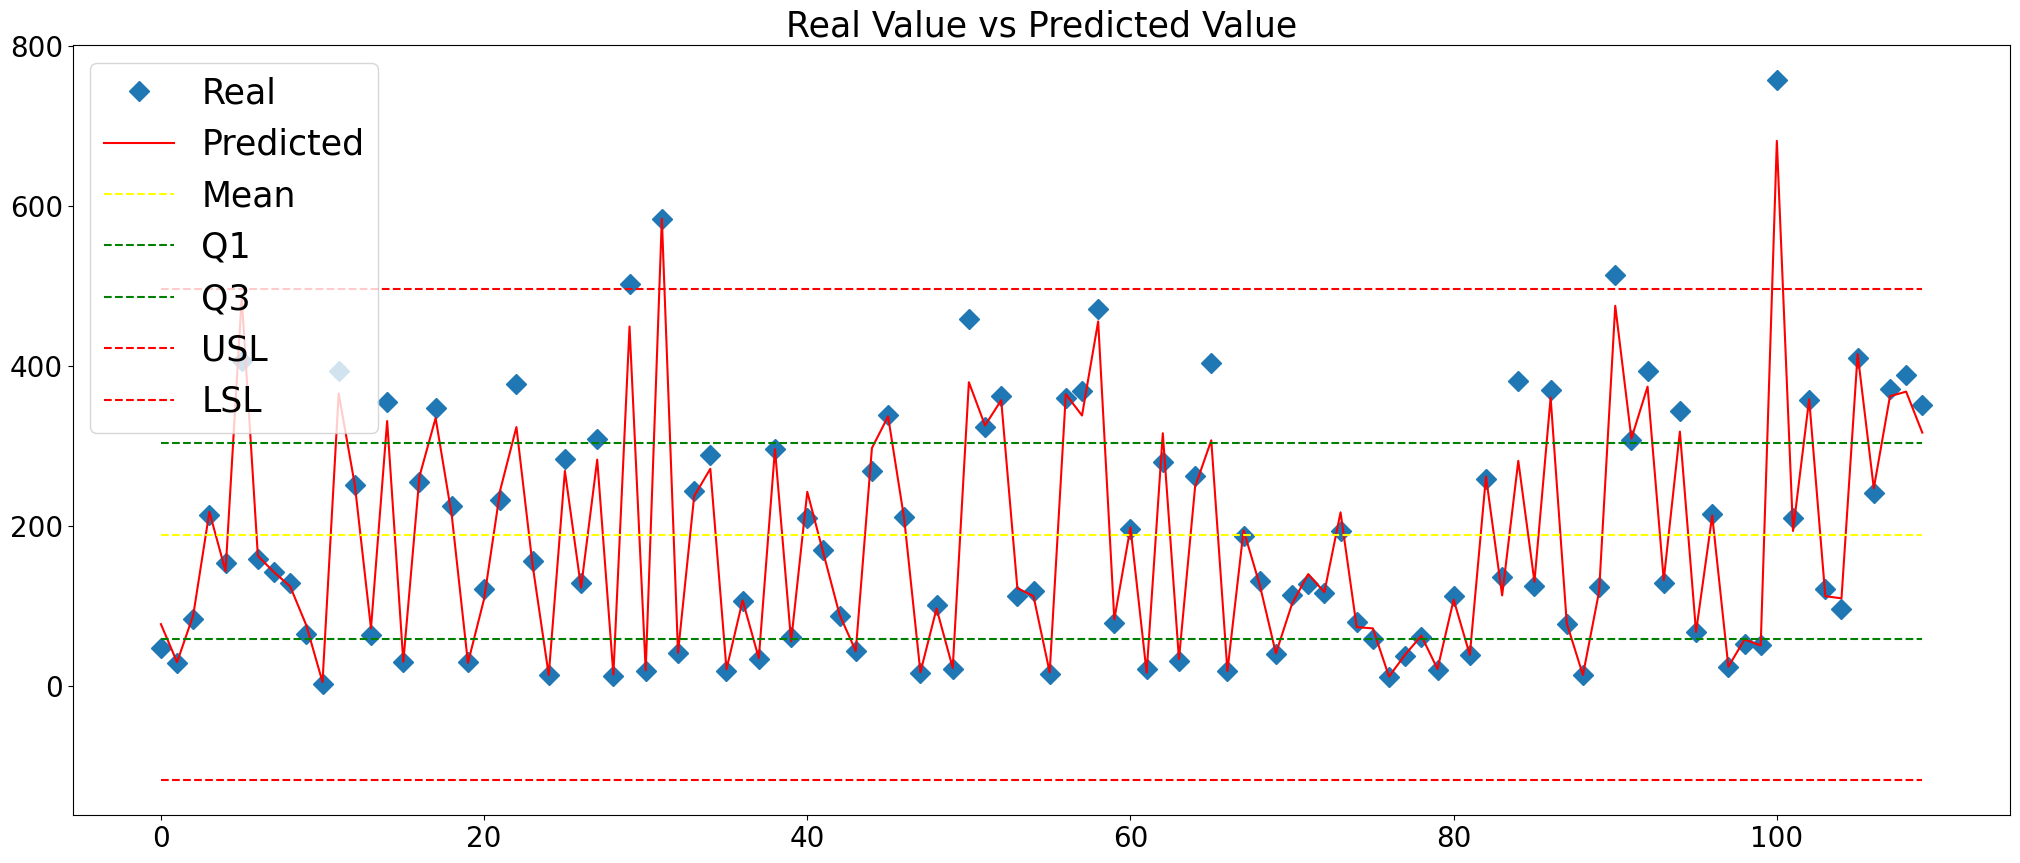

In [ ]:
# Graphic visualization of predictions by real values
plt.figure(figsize=(25,10))
plt.title('Real Value vs Predicted Value', fontsize=25)
plt.plot(df_comparison.index, df_comparison['Real_Data'], label = 'Real', marker='D', markersize=10, linewidth=0)
plt.plot(df_comparison.index, df_comparison['Predicted_Value'], label = 'Predicted', c='r', linewidth=1.5)
plt.plot(df_comparison.index, df_comparison['Average'], label = 'Mean', linestyle='dashed', c='yellow')
plt.plot(df_comparison.index, df_comparison['Q1'], label = 'Q1', linestyle='dashed',c='g')
plt.plot(df_comparison.index, df_comparison['Q3'], label = 'Q3', linestyle='dashed',c='g')

plt.plot(df_comparison.index, df_comparison['USL'], label = 'USL', linestyle='dashed',c='r')
plt.plot(df_comparison.index, df_comparison['LSL'], label = 'LSL', linestyle='dashed',c='r')

plt.legend(loc='best')
plt.legend(fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

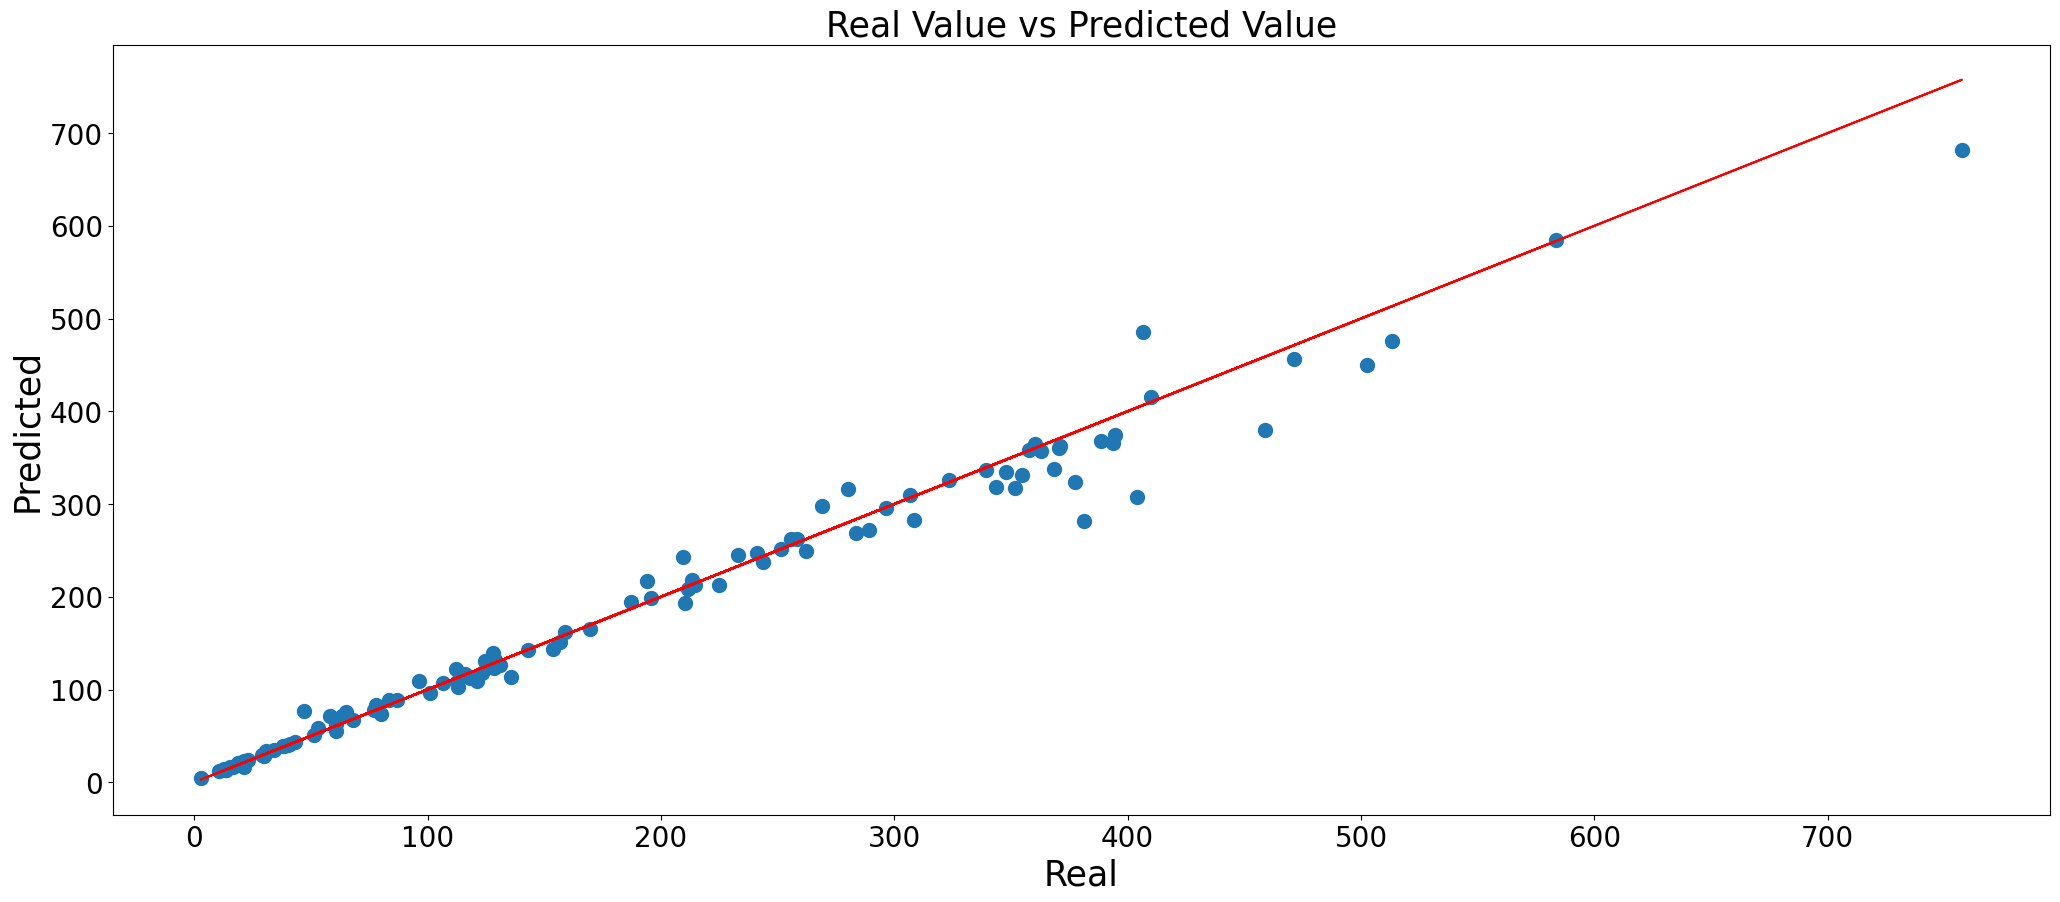

In [ ]:
# Graphic visualization of predictions by real values
plt.figure(figsize=(25,10))
plt.title('Real Value vs Predicted Value',fontsize=25)
plt.scatter(df_comparison['Real_Data'], df_comparison['Predicted_Value'], s=100)
plt.plot(df_comparison['Real_Data'],df_comparison['Real_Data'],c='r')

plt.xlabel('Real', fontsize=25)
plt.ylabel('Predicted', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

In [ ]:
column_names = list(df)
i=1
for names in column_names[:-1]:
    InputString = []
    for j in range(len(column_names)-1):
        if column_names[j] == names:
            InputString.append(50)
        else:
            InputString.append(0)
    print(names, pipe.predict([InputString])/50)
    i=i+1

Lipídeos [11.30927543]
Carboidrato [3.74451879]
Proteína [2.49572205]


## Testando alguns Exemplos

## Exemplo 1:
<img src="https://www.hidrolabor.com.br/imagens/informacoes/analise-tabela-nutricional-01.jpg" width="800" height="600">

Lembrando que usamos: X = df[["Lipídeos", "Carboidrato", "Proteína"]].values

In [ ]:
y_true = 83.0

In [ ]:
y_pred = pipe.predict([[2.2, 9.5, 6.2]])
y_pred

array([88.07067354])

In [ ]:
Erro = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'Erro: {Erro:.1f}%')


Erro: 6.1%


## Exemplo 2:
<img src="https://gepea.com.br/wp-content/uploads/2022/08/tabela.jpg" width="800" height="600">


In [ ]:
y_true = 76.0

In [ ]:
y_pred = pipe.predict([[2.6, 10.0, 2.6]])
y_pred

array([73.7593534])

In [ ]:
Erro = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'Erro: {Erro:.1f}%')

Erro: 2.9%


## Exemplo 3:
<img src="https://www.fnpbrasil.com.br/arquivos/tabela/BATATA-FRITA.png" width="800" height="600">

In [ ]:
y_true = 267.0

In [ ]:
y_pred = pipe.predict([[13.0, 35.0, 2.0]])
y_pred

array([262.79704147])

In [ ]:
Erro = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'Erro: {Erro:.1f}%')

Erro: 1.6%
